## Simulating any compartmental model with testing and quarantine using the `SppQ` class



In [1]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
#from matplotlib import rc; rc('text', usetex=True)

### The SIR model with quarantine

Below you will find the model-specification dictionary for the SIR model with quarantined states

In [2]:
model_spec = {
    "classes" : ["S", "I"],

    "S" : {
        "infection" : [ ["I", "-beta"] ],
    },

    "I" : {
        "linear"    : [ ["I", "-gamma"] ],
        "infection" : [ ["I", "beta"] ],
    },
    
    #                S              I           R
    "test_pos"  : [ "p_falsepos", "p_truepos", "p_falsepos"] ,
    "test_freq" : [ "pi_RS",      "pi_I",      "pi_RS"] 
}

parameters = {
    'beta' : 0.1,
    'gamma' : 0.1, 
    'p_falsepos' : 0.01,
    'p_truepos'  : 0.9,
    'pi_RS'      : 0.1,
    'pi_I'      : 1
    
}

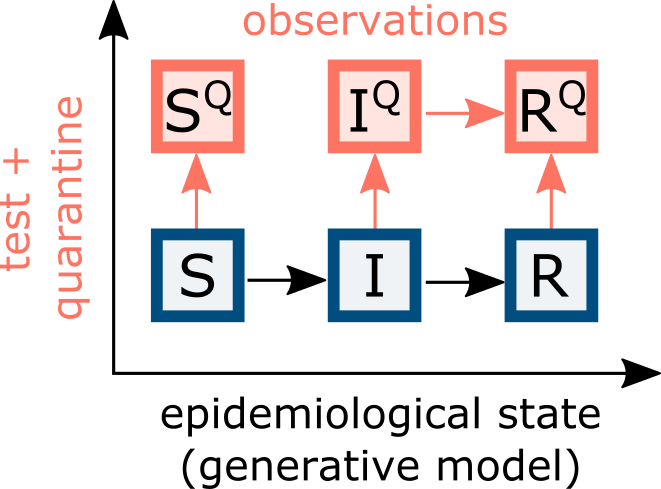

In [3]:
from IPython.display import Image
Image('SIRQ.png')

This corresponds to

$$
\begin{aligned}
\dot{S}_i & =  - \beta \sum_j C_{ij} \frac{I_j}{N_j} S_i - \tau_S S_i; &\dot{S}^Q_i & =  \tau_S S_i \\
\dot{I}_i & = \beta \sum_j C_{ij} \frac{I_j}{N_j} S_i - \gamma I_i - \tau_I I_i;
&\dot{I}^Q_i & =- \gamma I_i^Q+ \tau_I I_i\\
\dot{R}_i & = \gamma I_i- \tau_R R_i; &\dot{R}^Q_i & = \gamma I^Q_i+ \tau_R R_i;
\end{aligned}
$$

Each of the classes, `S`, `I` and `R`,  have a quarantined version, `SQ`, `IQ` and `RQ`. The dynamics within the quarantined states is the same as for the un-quarantined states, but there are no infection terms (assuming perfect quarantine). Individuals are quarantined upon testing positive, hence the total number $N^Q=S^Q+I^Q+R^Q$ would be the reported number of confirmed cases. 

The transition rates $\tau_S$, $\tau_I$, $\tau_R$ for irreversible transitions to the quarantined states are dependent on time and on other variables. They are determined by the overall testing rate $\tau_{tot}(t)$ and the parameters specified in `"test_pos"` and `"test_prob"` (ordered such that they match to `S`, `I` and `R`).  

- `"test_pos"` specifies the probability $\kappa_S$, $\kappa_I$, $\kappa_R$ that a test performed on an individual of a given class is positive. For classes $R$ and $S$, this is the conditional probability of false positives, for class $I$ the conditional probability of a true positive

- `"test_freq"` characterises the frequency $\pi_S$, $\pi_I$, $\pi_R$ of tests in a given class. The absolute values of these values does not matter, only their relative magnitudes. If we consider symptomatic testing and set $\pi_I=1$, then $\pi_R=\pi_S$ is the fraction of people who would like to be tested because of symptoms of flu or cold among the population *not* infected with SARS-CoV-2. In models with several infected classes, this parameter can also be used to prioritise testing of patients with severe symptoms or elderly people

- The rate of positive tests in each class is computed as
  $$ \tau_X=\tau_{tot}(t)\pi_X \kappa_X/\mathcal{N} $$
  for $X\in\{S,I,R\}$ with the normalisation constant
  $$ \mathcal{N}=\sum_X \pi_X  X$$

Next, we define the initial condition for all non-quarantined and quarantined states. $R$ is never specified but calculated from the total number. The initial value for $N^Q$ is specified for the auxiliary class `NiQ`. The (scalar) testing rate $\tau_{tot}(t)$ is specified as a Python function, similar to the time dependent contact matrix. Here, we specify a rapid increase from 10 to 100 tests per day around day 40.

In [4]:
M = 3                
Ni = 1000*np.ones(M)
N = np.sum(Ni) 


# Initial conditions as an array
x0 = np.array([
    990, 990, 990,   # S
    10,   10,  10,   # I
    0,   0,    0,    # R
    0,   0,    0,    # SQ
    0,   0,    0,    # IQ
    0,   0,    0,    # RQ
])



# Set up contact matrix
CM = np.array([
    [1,   0.5, 0.1],
    [0.5, 1,   0.5],
    [0.1, 0.5, 1  ]
], dtype=float)

def contactMatrix(t):  
    return CM

# Tests performed per day
def testRate(t):
    return (90.*(1.+np.tanh((t-40.)/10.))/2.+10.)

# duration of simulation and data file
Tf = 100;  Nf=Tf+1; 

model = pyross.deterministic.SppQ(model_spec, parameters, M, Ni)
# simulate model 
data = model.simulate(x0, contactMatrix, testRate, Tf, Nf)

# non-quarantined version for comarpison
model_specU = model_spec.copy()
model_specU.pop('test_freq')
model_specU.pop('test_pos')
modelU = pyross.deterministic.Spp(model_specU, parameters, M, Ni)
dataU = modelU.simulate(x0[0:(2*M)], contactMatrix, Tf, Nf)

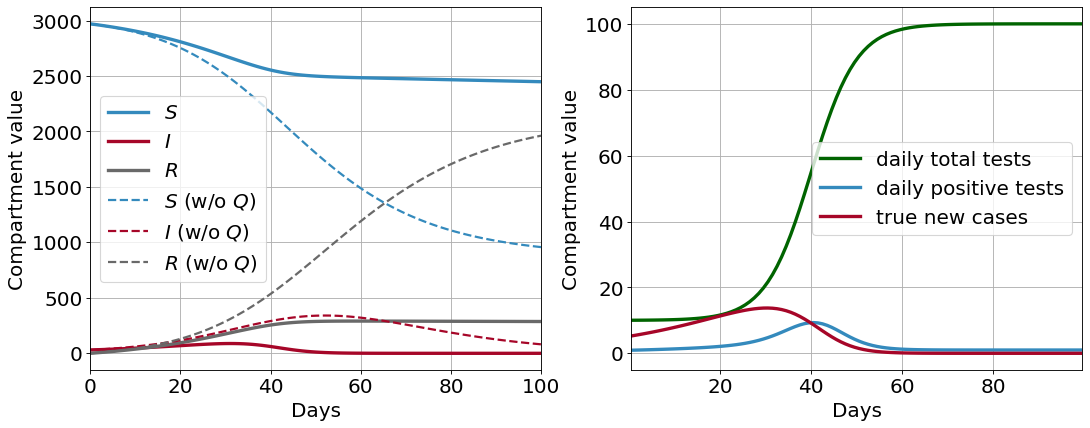

In [5]:
# plot the data and obtain the epidemic curve
S = np.sum(model.model_class_data('S', data), axis=1)
I = np.sum(model.model_class_data('I', data), axis=1)
R = np.sum(model.model_class_data('R', data), axis=1)
SQ = np.sum(model.model_class_data('SQ', data), axis=1)
IQ = np.sum(model.model_class_data('IQ', data), axis=1)
RQ = np.sum(model.model_class_data('RQ', data), axis=1)
NQ = np.sum(model.model_class_data('NiQ', data), axis=1)

SU = np.sum(modelU.model_class_data('S', dataU), axis=1)
IU = np.sum(modelU.model_class_data('I', dataU), axis=1)
RU = np.sum(modelU.model_class_data('R', dataU), axis=1)

t = data['t']

fig = plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 18})

plt.subplot(1, 2, 1)
plt.plot(t, S, '-', color="#348ABD", label='$S$', lw=3)
plt.plot(t, I, '-', color='#A60628', label='$I$', lw=3)
plt.plot(t, R, '-', color="dimgrey", label='$R$', lw=3)
plt.plot(t, SU, '--', color="#348ABD", label='$S$ (w/o $Q$)', lw=2)
plt.plot(t, IU, '--', color='#A60628', label='$I$ (w/o $Q$)', lw=2)
plt.plot(t, RU, '--', color="dimgrey", label='$R$ (w/o $Q$)', lw=2)

plt.legend(fontsize=18); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Compartment value')
plt.xlabel('Days');

plt.subplot(1, 2, 2)
tm = t[1:]-0.5
plt.plot(tm, [testRate(tt) for tt in tm], '-', color="darkgreen", label='daily total tests', lw=3)
plt.plot(tm, np.diff(NQ), '-', color="#348ABD", label='daily positive tests', lw=3)
plt.plot(tm, np.diff(I+R+IQ+RQ), '-', color="#A60628", label='true new cases', lw=3)

plt.legend(fontsize=18); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Compartment value')
plt.xlabel('Days');

In this simple model, testing and quarantining has helped to eradicate the disease. It is interesting to evaluate how many infections have been confired anf how many have remained unconfirmed:

In [6]:
print("Confirmed cases:", int(RQ[-1]))
print("Confirmed cases (incl. false positives):", int(NQ[-1]))
print("Total cases:", int(R[-1]+RQ[-1]))

Confirmed cases: 208
Confirmed cases (incl. false positives): 265
Total cases: 495


### SEAIMR model: Reported infections and deaths

Let us now look at a more complicated model. We assume there is no contact tracing in place, therefore asymptomatic infecteds are tested as likely as susceptibles and recovereds. Fatal cases are assigned a 5 fold increased priority for testing compared to symptomatic cases.

In [7]:
model_spec = {
    "classes" : ["S", "E", "A", "Ia", "Is", "Im"],

    "S" : {
        "infection" : [ ["A", "-beta"], ["Ia", "-beta"], ["Is", "-beta"] ]
    },

    "E" : {
        "linear"    : [ ["E", "-gammaE"] ],
        "infection" : [ ["A", "beta"], ["Ia", "beta"], ["Is", "beta"] ]
    },
    
    "A" : {
        "linear"    : [ ["E", "gammaE"], ["A", "-alphabar*gammaA"], ["A", "-alpha*gammaA"] ],
        "infection" : [ ]
    },

    "Ia" : {
        "linear"    : [ ["A", "alpha*gammaA"], ["Ia", "-gammaIa"] ],
        "infection" : [ ]
    },
    
    "Is" : {
        "linear"    : [ ["A", "alphabar*gammaA"], ["Is", "-cfrbar*gammaIs"], ["Is", "-cfr*gammaIs"] ],
        "infection" : [ ]
    },
    
    "Im" : {
        "linear"    : [ ["Is", "cfr*gammaIs"] ],
        "infection" : [ ]
    },
    
    #              S              E             A            Ia           Is           Im           R
    "test_pos"  : ["p_falsepos", "p_trueposE", "p_truepos", "p_truepos", "p_truepos", "p_truepos", "p_falsepos"],
    "test_freq" : ["pi_a",       "pi_a",       "pi_a",      "pi_a",      "pi_s",      "pi_m",      "pi_a"]
}

alpha = 0.3   # fraction of asymptomatic cases
beta  = 0.4   #infection rate 
cfr   = 0.01  # case fatality ratio
gE    = 0.04  # progression rate from E to A
gA    = 0.2   # progression rate from A to I
gIa   = 0.1   # removal rate of asymptomatic infectives
gIs   = 0.1   # removal rate of symptomatic infectives


parameters = {
    'beta' : beta,
    'gammaE' : gE, 
    'alpha*gammaA' : alpha*gA, 
    'alphabar*gammaA' : (1-alpha)*gA, 
    'gammaIa' : gIa, 
    'cfr*gammaIs' : cfr*gIs,
    'cfrbar*gammaIs' : (1-cfr)*gIs,
    'p_falsepos' : 0.01, # probability of false positives
    'p_truepos'  : 0.9,  # probability of true positive for infecteds
    'p_trueposE'  : 0.5, # probability of true positive for exposed
    'pi_a'      : 0.05,  # fraction of people with flu or cold
    'pi_s'      : 1,     # set to 1 for reference
    'pi_m'      : 5      # priority for testing fatal cases
    
}



In [8]:
M = 3                
Ni = 10000*np.ones(M)
N = np.sum(Ni) 

# Initial conditions as an array
x0 = np.array([
    9990, 9990, 9990,   # S
    10,   10,  10,   # E
    0,   0,    0,    # A
    0,   0,    0,    # Ia
    0,   0,    0,    # Is
    0,   0,    0,    # Im
    0,   0,    0,    # R
    0,   0,    0,    # SQ
    0,   0,    0,    # EQ
    0,   0,    0,    # AQ
    0,   0,    0,    # IaQ
    0,   0,    0,    # IsQ
    0,   0,    0,    # ImQ
    0,   0,    0,    # RQ
])

# Duration of simulation
Tf = 160

# Tests performed per day
def testRate(t):
    return (400.*(1.+np.tanh((t-40.)/10.))/2.+100.)

model = pyross.deterministic.SppQ(model_spec, parameters, M, Ni)
data = model.simulate(x0, contactMatrix, testRate, Tf, Nf)

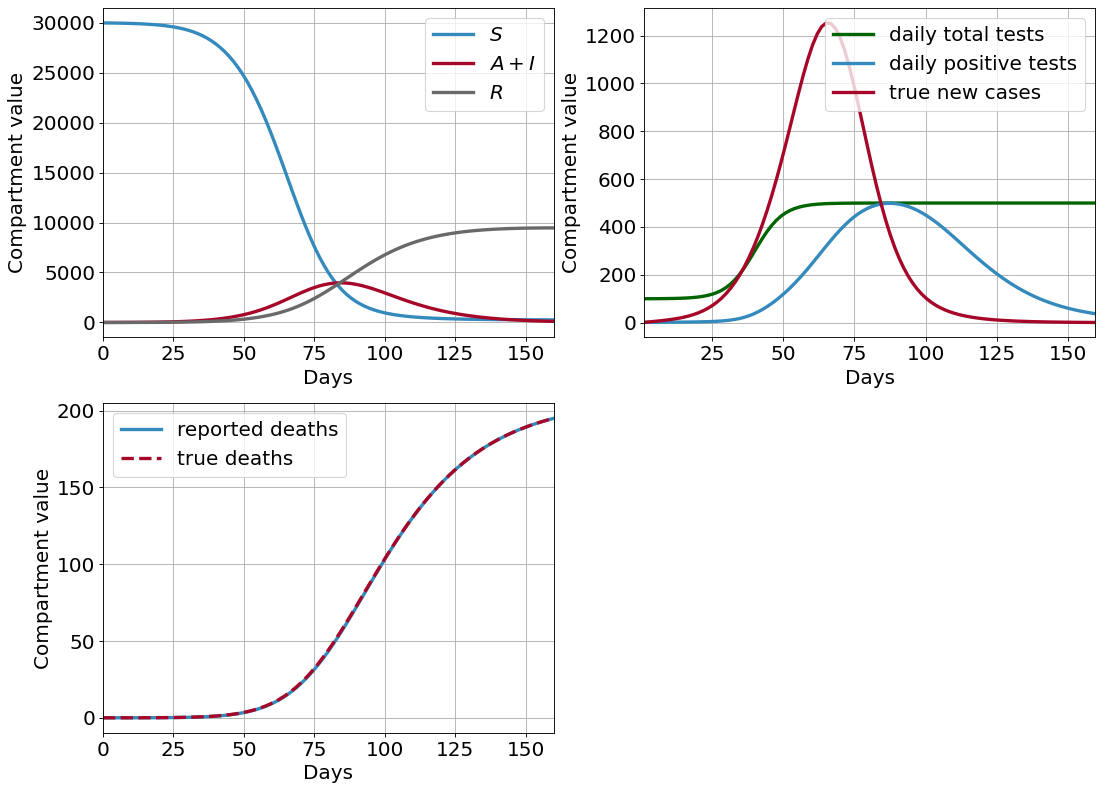

In [9]:
# plot the data and obtain the epidemic curve
S  = np.sum(model.model_class_data('S', data), axis=1)
E  = np.sum(model.model_class_data('E', data), axis=1)
A  = np.sum(model.model_class_data('A', data), axis=1)
Ia = np.sum(model.model_class_data('Ia', data), axis=1)
Is = np.sum(model.model_class_data('Is', data), axis=1)
Im = np.sum(model.model_class_data('Im', data), axis=1)
R  = np.sum(model.model_class_data('R', data), axis=1)
SQ  = np.sum(model.model_class_data('SQ', data), axis=1)
EQ  = np.sum(model.model_class_data('EQ', data), axis=1)
AQ  = np.sum(model.model_class_data('AQ', data), axis=1)
IaQ = np.sum(model.model_class_data('IaQ', data), axis=1)
IsQ = np.sum(model.model_class_data('IsQ', data), axis=1)
ImQ = np.sum(model.model_class_data('ImQ', data), axis=1)
RQ  = np.sum(model.model_class_data('RQ', data), axis=1)
NQ  = np.sum(model.model_class_data('NiQ', data), axis=1)



t = data['t']


fig = plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 18})

plt.subplot(2, 2, 1)
plt.plot(t, S, '-', color="#348ABD", label='$S$', lw=3)
plt.plot(t, A+Ia+Is+Im, '-', color='#A60628', label='$A+I$', lw=3)
plt.plot(t, R, '-', color="dimgrey", label='$R$', lw=3)


plt.legend(fontsize=18); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Compartment value')
plt.xlabel('Days');

plt.subplot(2, 2, 2)
tm = t[1:]-0.5
plt.plot(tm, [testRate(tt) for tt in tm], '-', color="darkgreen", label='daily total tests', lw=3)
plt.plot(tm, np.diff(NQ), '-', color="#348ABD", label='daily positive tests', lw=3)
plt.plot(tm, - np.diff(S+SQ), '-', color="#A60628", label='true new cases', lw=3)

plt.legend(fontsize=18); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Compartment value')
plt.xlabel('Days');

plt.subplot(2, 2, 3)
plt.plot(t, ImQ, '-', color="#348ABD", label='reported deaths', lw=3)
plt.plot(t, Im+ImQ, '--', color='#A60628', label='true deaths', lw=3)


plt.legend(fontsize=18); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Compartment value')
plt.xlabel('Days');